In [104]:
import pandas as pd

In [105]:
# Read data using pandas
dfpop = pd.read_csv     (r'Data/populationdata.csv')
dfpop.head()

,City,State,population,Lon,Lat
0,Henderson,Nevada,260068,-115.0375,36.0122
1,Manchester,New Hampshire,109830,-71.4439,42.9847
2,Elizabeth,New Jersey,125660,-74.1935,40.6663
3,Newark,New Jersey,277540,-74.1726,40.7242
4,Paterson,New Jersey,146427,-74.1628,40.9147


In [106]:
dftemp = pd.read_csv (r'Data/temperaturedata.csv')
dftemp.head()

,name,country_name,country_code,continent,station_code,location_date,temp_mean_c,temp_min_c,temp_max_c
0,Atlanta,UnitedStates,USA,North America,KATL,4/20/2021,17.491667,12.2,23.3
1,Windsor Locks,UnitedStates,USA,North America,KBDL,4/20/2021,13.887500,3.9,22.2
2,Nashville,UnitedStates,USA,North America,KBNA,4/20/2021,15.175000,6.7,23.3
3,Boise,UnitedStates,USA,North America,KBOI,4/20/2021,9.329167,1.7,15.6
4,Boston,UnitedStates,USA,North America,KBOS,4/20/2021,16.716667,10.0,23.9


In [107]:
#check for NaN in dftemp
NaNsum = dftemp.isna().sum().sum()

In [108]:
#if NaN > 0, drop
if(NaNsum > 0): 
    dftemp.dropna()
    df.head()
else: 
    print('No NaNs')

No NaNs


In [109]:
from sklearn import neighbors 
from sklearn.model_selection import train_test_split

#drop name, country_name, country_code, continent
dftemp.drop(columns=[
    'name', 
    'country_name', 
    'country_code', 
    'continent'
], inplace=True)
dftemp.head()

,station_code,location_date,temp_mean_c,temp_min_c,temp_max_c
0,KATL,4/20/2021,17.491667,12.2,23.3
1,KBDL,4/20/2021,13.887500,3.9,22.2
2,KBNA,4/20/2021,15.175000,6.7,23.3
3,KBOI,4/20/2021,9.329167,1.7,15.6
4,KBOS,4/20/2021,16.716667,10.0,23.9


In [110]:
#need to replace dates with datetime objects
import seaborn as sns 
import datetime as dt


dftemp['date_parsed'] = pd.to_datetime(dftemp['location_date'], infer_datetime_format=True)

#drop old dates
dftemp.drop(columns=['location_date'], inplace=True)



In [111]:
#group by station
grouped = dftemp.groupby(dftemp.station_code)
df_KATL = grouped.get_group("KATL")
#sort by date
df_KATL.set_index('date_parsed', inplace=True)
df_KATL.sort_index(inplace=True)
df_KATL.head()

<ipython-input-111-11bcd161999e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_KATL.sort_index(inplace=True)


,station_code,temp_mean_c,temp_min_c,temp_max_c
date_parsed,,,,
2015-01-01,KATL,6.758333,0.0,13.9
2015-01-02,KATL,8.116667,6.7,9.4
2015-01-03,KATL,11.154167,8.9,16.1
2015-01-04,KATL,14.279167,6.7,17.8
2015-01-05,KATL,5.045833,1.1,8.9


In [112]:
y = df_KATL.temp_mean_c 
y.index.name = 'date'
y = y.resample('1D').last()
y.head()

date
2015-01-01     6.758333
2015-01-02     8.116667
2015-01-03    11.154167
2015-01-04    14.279167
2015-01-05     5.045833
Freq: D, Name: temp_mean_c, dtype: float64

Text(0, 0.5, 'avg temp')

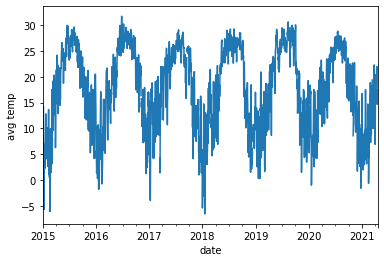

In [113]:
ax = y.plot()
ax.set_ylabel('avg temp')

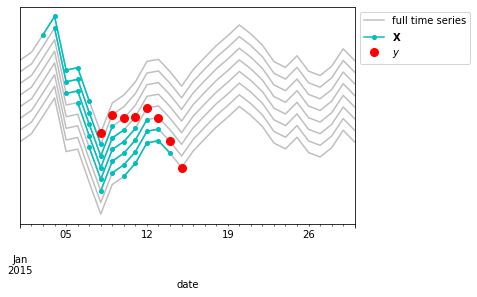

In [114]:
import numpy as np

#lets see what a time series for january would look like
fig, ax = plt.subplots()

start = np.where(y.index == '2015-01-01')[0][0]
middle = np.where(y.index == '2015-01-15')[0][0]
end = np.where(y.index == '2015-01-31')[0][0]

window = 5

for i in range(8): 
    full = y.iloc[start:end]
    train = y.iloc[middle - i - window:middle - i]
    predict = y.iloc[middle - i:middle - i + 1]

    (full + 2*i).plot(ax=ax, c='grey', alpha = 0.5)
    (train + 2*i).plot(ax=ax, c ='c', markersize=4, marker='o')
    (predict+2*i).plot(ax=ax, c='r', markersize=8, marker='o', linestyle='')

ax.get_yaxis().set_ticks([])
ax.legend(['full time series', '$\mathbf{X}$', '$y$'], bbox_to_anchor=(1, 1))


In [115]:
window = 5
num_samples = 8

X_mat = []
y_mat = []

for i in range(num_samples): 
    X_mat.append(y.iloc[middle-i-window:middle - i].values)
    y_mat.append(y.iloc[middle-i:middle - i + 1].values)

X_mat = np.vstack(X_mat)
y_mat = np.concatenate(y_mat)

assert X_mat.shape == (num_samples, window)
assert len(y_mat) == num_samples

In [116]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression(fit_intercept=False)
lr = lr.fit(X_mat, y_mat)
y_pred = lr.predict(X_mat)